# Portfolio Optimization Project

---

## 1. Objective

The objective of this project is to build a portfolio optimization framework that maximizes the **Sharpe ratio**, subject to realistic investment constraints, while explicitly acknowledging the limitations of mean - variance optimization and the relevance of tail risk (CVaR) for real-world portfolios.

Although the optimization target is Sharpe ratio, the project is designed from the beginning with a risk-aware perspective, where downside and stress behavior will later be evaluated using CVaR and stress scenarios.

---

## 2. Asset Selection
The portfolio universe consists of USD-denominated assets, selected to provide sectoral diversification within equities and a systemic hedge component.

| Ticker | Asset Class | Portfolio Role | Main Risk | Dominant Factor | Behavior Under Stress |
|--------|-------------|----------------|-----------|-----------------|-----------------------|
| AAPL | Equity (Tech, USA) | Growth / core equity | Market risk (beta), mega-cap concentration, consumer/tech cycle | Growth / Quality | No (high equity correlation under stress) |
| NVDA | Equity (Tech/AI, USA) | High growth (return driver) | High volatility, valuation risk, large drawdowns | Growth / Momentum | No (severe drawdowns under stress) |
| TSM | Equity (Semiconductors, Asia) | Global semiconductor exposure | Geopolitical risk, industry concentration, high cyclicality | Growth / Industrial cycle | No (geopolitical + equity risk) |
| JPM | Equity (Banking, USA) | Sector diversification (financials) | Credit cycle risk, interest rates, systemic financial stress | Value / Rates | No (sensitive to financial crises) |
| MA | Equity (Payments, USA) | Non-bank financial exposure | Consumer activity, regulation, growth-financial valuation risk | Growth / Consumption | No (sensitive to economic cycle) |
| LMT | Equity (Defense, USA) | Relative defensive asset | Government budgets, contract execution, geopolitical events | Defensive / Government spending | Yes (relatively resilient) |
| GLD | ETF (Gold, USD) | Systemic hedge + FX protection | Commodity volatility, sensitivity to real rates and USD strength | Inflation / Safe haven | Yes (safe-haven asset) |


---

## 3. Qualitative Risk Classification
Before any numerical optimization, each asset is classified according to:

- its **economic role in the portfolio**,  
- its **dominant risk factor**, and  
- its **expected behavior during stress periods**.

This qualitative layer is used to:
- justify portfolio constraints,
- interpret optimization results,
- detect factor concentration (e.g., growth/technology dominance),
- support risk conclusions beyond purely statistical outputs.

---

## 4. Portfolio Constraints and Implementability
To avoid unstable or unrealistic solutions commonly produced by unconstrained Sharpe maximization, the following constraints are imposed:

- **Long-only portfolio:**  
  $ w_i \ge 0 $
- **Fully invested portfolio:**  
  $\sum_i w_i = 1$
- **Maximum weight per asset:**  
  $w_i \le 30\%$
- **Minimum weight per asset:**  
  $w_i \ge 0\%$




In [73]:
#Importing libraries
import pypfopt 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from pypfopt import EfficientFrontier

In [74]:
#Setting display options for pandas DataFrames
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [75]:
Constraints = {
    "long_only": True,
    "w_sum": 1.0,
    "w_min": 0.0,
    "w_max": 0.3
}

---
## 5. Data Acquisition and Return Construction

### 5.1 Historical Data Source

Historical price data is obtained using the `yfinance` library. The dataset consists of daily **closing prices** for the selected USD-denominated assets:

- AAPL
- NVDA
- TSM
- JPM
- MA
- LMT
- GLD

The data sample begins in 2020 to ensure:

- sufficient observations for covariance estimation  
- inclusion of multiple market regimes (COVID shock, rate hiking cycle, etc.)  
- statistically meaningful estimation window  


In [76]:
tickers = ["AAPL", "GLD", "TSM", "NVDA", "JPM", "MA", "LMT"]

In [77]:
data = yf.download(tickers , start="2020-01-01", end="2026-02-20")


[*********************100%***********************]  7 of 7 completed


In [78]:
data = data["Close"]

---
### 5.2 Data Cleaning

Since different assets may not trade on identical calendars, the dataset is aligned by:

- retaining only common trading dates across all assets  
- removing rows with missing values  

In [79]:
data.isna().sum()

Ticker
AAPL    0
GLD     0
JPM     0
LMT     0
MA      0
NVDA    0
TSM     0
dtype: int64

In [80]:
data = data.dropna()

In [81]:
data.isna().sum()

Ticker
AAPL    0
GLD     0
JPM     0
LMT     0
MA      0
NVDA    0
TSM     0
dtype: int64

<Axes: title={'center': 'Stock Prices'}, xlabel='Date', ylabel='Price ($)'>

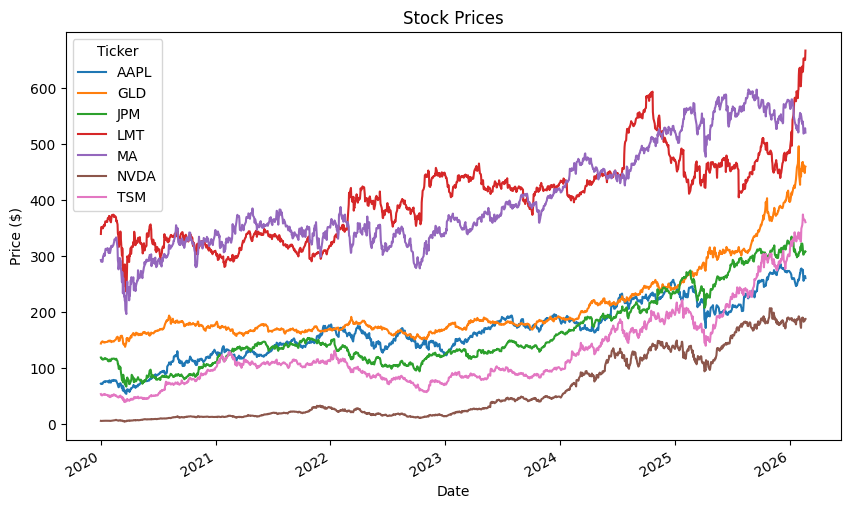

In [82]:
data.plot(figsize=(10, 6), title="Stock Prices", ylabel="Price ($)", xlabel="Date")

The figure shows the historical adjusted closing prices of all selected assets. 
We observe heterogeneous growth patterns and volatility structures across assets:

- NVDA and TSM show strong growth but high volatility.
- GLD has lower volatility and more defensive behavior.
- LMT seems to have relatively resilient during market stress periods.
- JPM shows cyclical dynamics consistent with financial sector exposure.

These differences suggest potential diversification benefits, which will be formally assessed through return correlations and covariance analysis.


---
### 5.3 Return Definition

Returns are computed using logarithmic returns:

$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$

Log returns are chosen because:

- they are additive over time  
- they are consistent with continuous compounding  
- they exhibit better statistical properties for modeling  

These daily log returns form the basis for:

- expected return estimation  
- covariance matrix estimation  
- Sharpe ratio optimization  
- tail risk analysis  

In [83]:
log_returns = data.pct_change().dropna()
log_returns.dropna()
log_returns.head()

Ticker,AAPL,GLD,JPM,LMT,MA,NVDA,TSM
Date,,,,,,,
2020-01-03,-0.009722,0.013269,-0.013196,0.035982,-0.009757,-0.016006,-0.032978
2020-01-06,0.007968,0.010490,-0.000795,-0.001523,0.002663,0.004194,-0.011540
2020-01-07,-0.004703,0.003935,-0.017000,0.003365,-0.003386,0.012107,0.016205
2020-01-08,0.016086,-0.007502,0.007801,-0.008372,0.017645,0.001876,0.007373
2020-01-09,0.021241,-0.005652,0.003651,0.009489,0.013110,0.010983,0.008170


### 5.4 Descriptive Statistics

Before proceeding to optimization, summary statistics are computed:

- mean  
- standard deviation  
- skewness  
- kurtosis  

This step allows preliminary assessment of:

- volatility dispersion across assets  
- asymmetry in return distributions  
- presence of fat tails  

The presence of skewness and excess kurtosis would indicate deviations from normality, which has implications for risk estimation and Sharpe interpretation.


In [84]:
summary_stats = log_returns.describe().T
summary_stats["skew"] = log_returns.skew()
summary_stats["kurtosis"] = log_returns.kurtosis()
summary_stats.drop(columns=["count"], inplace=True)
summary_stats


,mean,std,min,25%,50%,75%,max,skew,kurtosis
Ticker,,,,,,,,,
AAPL,0.001031,0.019987,-0.128647,-0.008207,0.001096,0.011208,0.153288,0.281131,6.739850
GLD,0.000815,0.011036,-0.102742,-0.004678,0.000923,0.006604,0.063587,-0.696428,7.758331
JPM,0.000811,0.019716,-0.149649,-0.008007,0.000976,0.010004,0.180125,0.351131,12.769286
LMT,0.000577,0.016620,-0.127616,-0.006113,0.000634,0.007832,0.107279,-0.554644,12.541875
MA,0.000547,0.018691,-0.127255,-0.007935,0.000780,0.009171,0.166109,0.386652,10.325730
NVDA,0.002792,0.033302,-0.184521,-0.015479,0.003151,0.021503,0.243696,0.358564,4.561019
TSM,0.001534,0.024454,-0.140341,-0.012733,0.000683,0.014555,0.126522,0.232568,3.199830


This section presents a descriptive statistical analysis of the daily log-returns for the selected assets:

- AAPL  
- GLD  
- JPM  
- LMT  
- MA  
- NVDA  
- TSM  


#### a. Mean — Average Daily Return

The `mean` column represents the average daily return.

Example observations:

- NVDA ≈ 0.0027
- TSM ≈ 0.00153  
- AAPL ≈ 0.001031  

Interpretation:

- NVDA shows the highest expected return.
- TSM and AAPL provide moderate growth.
- GLD and LMT display lower average returns.

Higher expected return increases portfolio growth potential but typically comes with higher volatility and tail risk.


#### b. Standard Deviation — Volatility (Risk)

The `std` column measures daily volatility.

Observations:

- TSM and NVDA exhibit the highest volatility.
- GLD shows the lowest volatility.

Interpretation:

Volatility measures dispersion of returns:

- High volatility means larger price fluctuations.
- Low volatility means potential stabilizer within portfolios.

#### c. Minimum — Worst Observed Daily Loss

The `min` column captures the largest historical daily loss.

Examples:

- NVDA ≈ -18.45%
- JPM ≈ -14.96%
- TSM ≈ -14.03%

Interpretation:

These values reflect realized extreme downside risk.  
Such magnitudes are typically underestimated under normality assumptions.

#### d. Maximum — Best Observed Daily Gain

The `max` column shows extreme positive returns.

Example:

- NVDA ≈ 24.36%

Interpretation:

Large upside movements often accompany large downside risks, indicating event-driven or high-convexity behavior.


#### e. Skewness — Distribution Asymmetry

Skewness measures asymmetry:

- Positive skew shows longer right tail (extreme gains)
- Negative skew means heavier left tail (extreme losses)

Observations:

- NVDA shows slight positive skew.
- GLD and LMT show negative skew.

Interpretation:

Negative skew implies vulnerability to sudden downside shocks.

#### f. Kurtosis — Tail Thickness

A normal distribution has kurtosis ≈ 3.

Observed values:

- JPM ≈ 12.76
- LMT ≈ 12.54
- GLD ≈ 7.75
- AAPL ≈ 6.73
- NVDA ≈ 4.56

Interpretation:

All assets have fat tails.

This implies:

- Higher probability of extreme events.
- Parametric VaR (normal assumption) may underestimate risk.
- CVaR becomes more relevant for tail-sensitive analysis.

#### g. Conclusion

1. Returns are clearly non-normal.
2. Tail risk is significant across assets.
3. High return assets (NVDA, TSM) also exhibit high volatility.
4. GLD provides volatility reduction but is not tail risk free.
5. Financial exposure (JPM) shows systemic shock sensitivity because of its high kurtosis.






---
### 5.5 Annualization

To align with annualized performance metrics, daily statistics are scaled assuming 252 trading days per year:

$\mu_{annual} = \mu_{daily} \times 252$


$\Sigma_{annual} = \Sigma_{daily} \times 252$

This produces:

- an annualized expected return vector  
- an annualized covariance matrix  

These two elements are the core inputs required for mean–variance optimization.


In [85]:
year = 252

mu = log_returns.mean() * year
sigma = log_returns.cov() * year

mu,sigma

(Ticker
 AAPL    0.259807
 GLD     0.205433
 JPM     0.204465
 LMT     0.145513
 MA      0.137877
 NVDA    0.703680
 TSM     0.386501
 dtype: float64,
 Ticker      AAPL       GLD       JPM       LMT        MA      NVDA       TSM
 Ticker                                                                      
 AAPL    0.100667  0.004723  0.041775  0.021116  0.054276  0.096108  0.060155
 GLD     0.004723  0.030692  0.000147  0.004764  0.002995  0.009248  0.009324
 JPM     0.041775  0.000147  0.097962  0.029960  0.056246  0.056406  0.044555
 LMT     0.021116  0.004764  0.029960  0.069607  0.027776  0.014541  0.012036
 MA      0.054276  0.002995  0.056246  0.027776  0.088039  0.070263  0.043651
 NVDA    0.096108  0.009248  0.056406  0.014541  0.070263  0.279468  0.139278
 TSM     0.060155  0.009324  0.044555  0.012036  0.043651  0.139278  0.150691)

#### 5.5.1. Return Analysis (Annualized Mean)

The annualized mean represents the expected return if historical dynamics persist.

From the results:

- **NVDA** shows the highest annualized return, this means it is strongest growth driver.
- **TSM** and **AAPL** follow as solid growth assets.
- **JPM** and **MA** show moderate expected returns.
- **GLD** and **LMT** exhibit lower expected returns, so they have a more defensive profile.

NVDA is the primary return engine of the portfolio, but it likely comes with substantial volatility. GLD and LMT provide lower expected returns but may contribute stability and diversification.

#### 5.5.2. Risk Analysis (Annualized Standard Deviation)

Annualized volatility measures total risk exposure.

From the statistics:

- **NVDA** has the highest volatility
- **TSM** and **AAPL** also show elevated volatility.
- **JPM** and **MA** are moderately volatile.
- **GLD** and **LMT** exhibit lower volatility.

NVDA is the most unstable asset in the portfolio, GLD behaves as a volatility stabilizer and LMT may act as a relative defensive equity due to government exposure.





## 5.6 Correlation Structure


### 5.6.1 Correlation Matrix

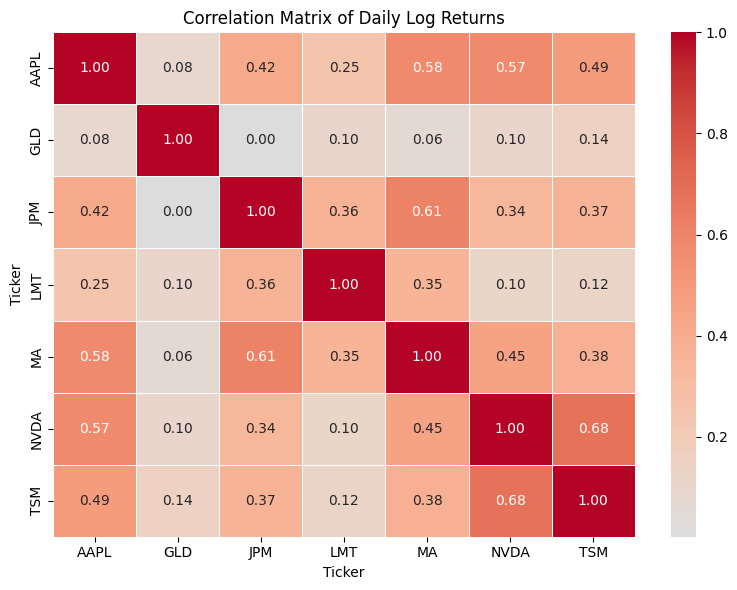

In [86]:
corr = log_returns.corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Daily Log Returns")
plt.tight_layout()
plt.show()

In [109]:
# Top correlated pairs
corr_pairs = corr.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool)
)

corr_pairs = corr_pairs.unstack().dropna()

top_pairs = corr_pairs.sort_values(ascending=False).head(10)
bottom_pairs = corr_pairs.sort_values().head(10)

top_pairs,bottom_pairs

(Ticker  Ticker
 TSM     NVDA      0.678689
 MA      JPM       0.605657
         AAPL      0.576533
 NVDA    AAPL      0.572992
 TSM     AAPL      0.488410
 NVDA    MA        0.447940
 JPM     AAPL      0.420671
 TSM     MA        0.378974
         JPM       0.366715
 LMT     JPM       0.362823
 dtype: float64,
 Ticker  Ticker
 JPM     GLD       0.002685
 MA      GLD       0.057611
 GLD     AAPL      0.084969
 NVDA    GLD       0.099860
 LMT     GLD       0.103064
 NVDA    LMT       0.104258
 TSM     LMT       0.117517
         GLD       0.137103
 LMT     AAPL      0.252254
 NVDA    JPM       0.340901
 dtype: float64)


### Most Correlated Pairs (Cluster Detection)

The strongest correlations observed in the portfolio are:

- **TSM – NVDA:** 0.679  
- **MA – JPM:** 0.606  
- **MA – AAPL:** 0.576  
- **NVDA – AAPL:** 0.573  
- **TSM – AAPL:** 0.489  

Two dominant clusters emerge clearly:

**Technology / Semiconductor Cluster**
- NVDA, TSM, and AAPL exhibit strong internal correlations.
- The highest correlation in the dataset (TSM–NVDA = 0.679) confirms strong exposure to the semiconductor/AI growth factor.
- This implies potential concentration risk if these assets receive large weights in an optimized portfolio.

**Financial / Payments Cluster**
- MA and JPM show high correlation (0.606).
- This reflects exposure to the financial cycle and consumer spending activity.
- Including both in high weights may not provide meaningful diversification benefits.

### Least Correlated Pairs (Diversification Potential)

The weakest correlations include:

- **JPM – GLD:** 0.0026 
- **MA – GLD:** 0.0576  
- **GLD – AAPL:** 0.0849  
- **NVDA – GLD:** 0.099  
- **LMT – GLD:** 0.103  

**GLD seems to be the main diversifier.**

- Correlations between GLD and equities are close to zero.
- This suggests that gold behaves largely independently from equity market movements during the sample period.
- From a portfolio construction perspective, GLD can reduce overall variance through low cross-correlation effects.



### 5.6.2 Rolling Correlation Analysis

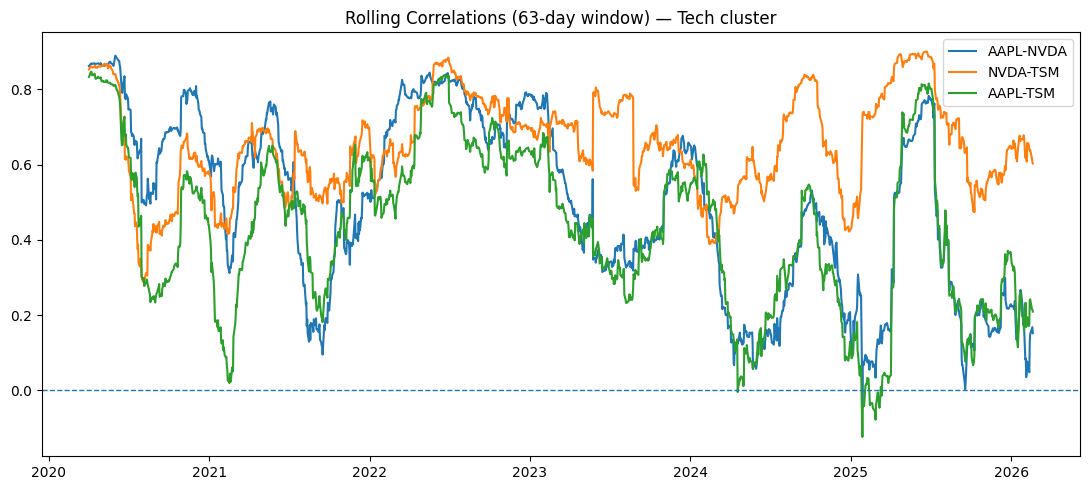

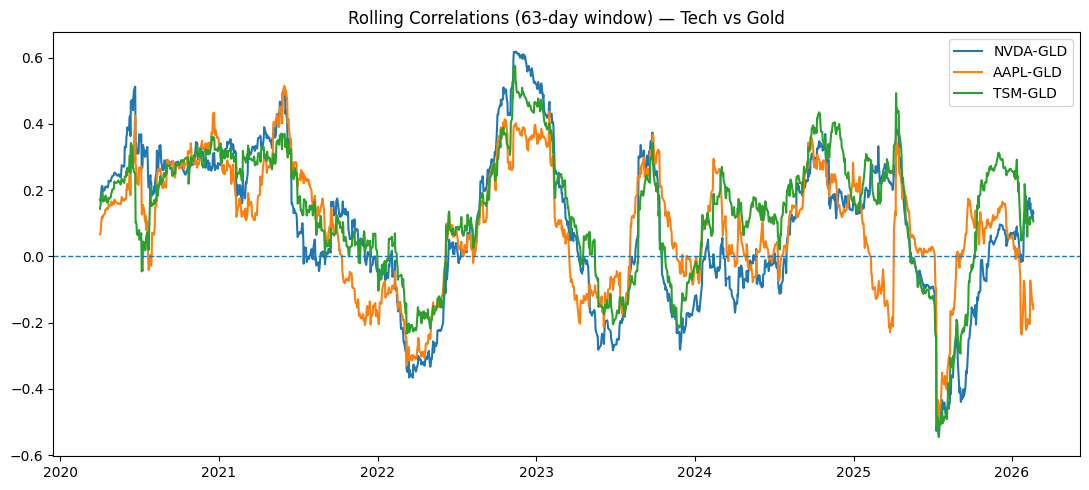

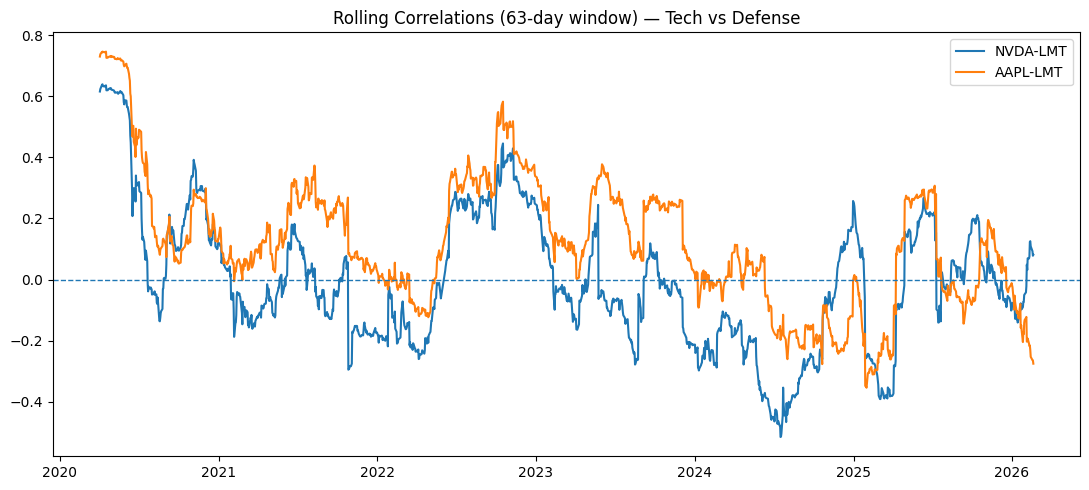

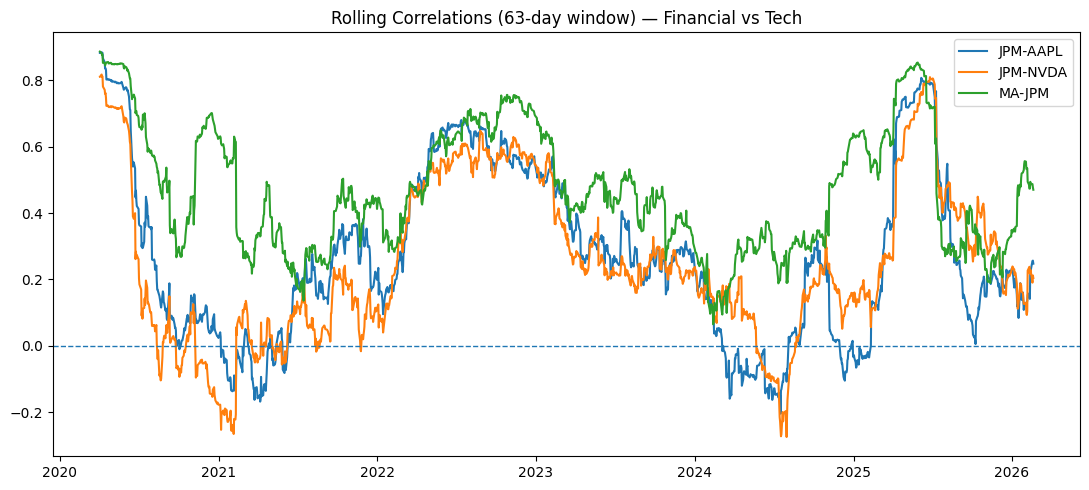

In [88]:
window = 63 

pairs = {
    "Tech cluster": [("AAPL","NVDA"), ("NVDA","TSM"), ("AAPL","TSM")],
    "Tech vs Gold": [("NVDA","GLD"), ("AAPL","GLD"), ("TSM","GLD")],
    "Tech vs Defense": [("NVDA","LMT"), ("AAPL","LMT")],
    "Financial vs Tech": [("JPM","AAPL"), ("JPM","NVDA"), ("MA","JPM")]
}

def rolling_corr(series_a, series_b, window):
    return series_a.rolling(window).corr(series_b)

for title, pair_list in pairs.items():
    plt.figure(figsize=(11,5))
    
    for a, b in pair_list:
        rc = rolling_corr(log_returns[a], log_returns[b], window)
        plt.plot(rc.index, rc.values, label=f"{a}-{b}")
    
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title(f"Rolling Correlations ({window}-day window) — {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Tech Cluster (AAPL–NVDA–TSM)

### Observations
- Correlations are **consistently high (0.4–0.9)** for most of the sample.
- During stress regimes (2020, 2022, parts of 2024–2025), correlations spike toward **0.8–0.9**.
- In calmer periods, correlations decline but rarely fall below ~0.3.

### Interpretation
- This is a **highly concentrated growth/semiconductor factor cluster**.
- Diversification inside tech is limited — especially during stress.
- NVDA–TSM often shows the strongest linkage, confirming semiconductor cyclicality.
- AAPL behaves slightly more defensively but remains structurally correlated.

### Risk Insight
If portfolio weights are concentrated in this cluster, downside risk becomes **factor-driven**, not stock-specific.


###  Tech vs Gold (GLD)

### Observations
- Correlations fluctuate between **+0.4 and –0.4**.
- Several clear **negative regimes** (2022 tightening cycle, parts of 2024–2025).
- Correlations are unstable and regime-dependent.

### Interpretation
- Gold acts as a **partial hedge**, but not consistently.
- In inflation or rate shock environments, tech–gold correlation tends to fall or turn negative.
- In liquidity-driven bull markets, correlation can turn positive.

### Risk Insight
GLD provides **conditional diversification**, not structural independence.


###  Tech vs Defense (LMT)

### Observations
- Correlations range from +0.6 to –0.4.
- Often weakly positive or near zero.
- In some stress periods, correlation turns negative.

### Interpretation
- LMT behaves as a **defensive cyclical asset**, not a pure hedge.
- It provides moderate diversification vs high-beta tech.
- However, during broad equity sell-offs, correlation increases.

### Risk Insight
LMT reduces portfolio volatility relative to tech-only exposure but does not eliminate systematic risk.

### Financial vs Tech (JPM relationships)

### Observations
- High correlation during expansion regimes (~0.6–0.8).
- Sharp breakdowns in 2020 and 2023–2024 (bank stress periods).
- Sometimes correlation drops near zero or negative.

### Interpretation
- JPM is tied to macro cycle and credit conditions.
- During financial stress, diversification benefits increase.
- During bull markets, financials move with tech.

### Risk Insight
Financials introduce **cyclical diversification**, but correlation is state-dependent.


### Regime Behavior Summary

| Regime | Tech Cluster | Tech vs Gold | Tech vs Defense | Financial vs Tech |
|--------|-------------|-------------|----------------|------------------|
| 2020 COVID | Correlation spike | Mixed | Mixed | Breakdown |
| 2022 Rate Hikes | High internal tech correlation | Negative vs gold | Weak | Moderate |
| 2023 AI Rally | Very high tech correlation | Slight positive | Positive | High |
| 2024–2025 Volatility | Clustered risk | Mixed hedge | Partial hedge | Cyclical shifts |


## 6. Portfolio Optimization - Sharpe Ratio

### 6.1 Portfolio Weights
Let there be $N$ assets with returns $R_1, \dots, R_N$.  
Define the **portfolio weights**:


$w = (w_1, w_2, \dots, w_N)^\top$

- $w_i$ represents the fraction of total capital invested in asset \(i\).
- In long-only portfolios: $w_i \ge 0$.
- Full investment: $\sum_{i=1}^N w_i = 1$.


### 6.2 Expected Return as a Linear Combination

Let $\mu = (\mu_1, \dots, \mu_N)^\top$ be the vector of **expected returns**.  
The portfolio’s expected return is:


$\mu_p = \mathbb{E}[R_p] = w^\top \mu$

This is a **linear** relationship: doubling a weight doubles that asset’s contribution to expected return.




In [89]:
def portfolio_return(w,mu):
    return np.dot(w, mu)

### 6.3 Portfolio Risk (Volatility)

Let $\Sigma$ be the $N \times N$ **covariance matrix** of asset returns.


$\Sigma_{ij} = \text{Cov}(R_i, R_j)$

The portfolio variance is:


$\sigma_p^2 = \text{Var}(R_p) = w^\top \Sigma w$

and volatility (standard deviation):


$\sigma_p = \sqrt{w^\top \Sigma w}$

Key interpretation:
- Risk is not just individual volatilities.
- **Correlations/covariances drive diversification** via cross-terms.

Expanded form:


$\sigma_p^2 = \sum_{i=1}^N w_i^2\sigma_i^2 + 2\sum_{i<j} w_i w_j \sigma_i \sigma_j \rho_{ij}$

Where $\rho_{ij}$ is correlation.

**Diversification works** when $\rho_{ij}$ is low or negative.







In [90]:
def portfolio_volatility(w, Sigma):
    return np.sqrt(np.dot(w.T, np.dot(Sigma, w)))

### 6.4 Risk-Adjusted Performance: Sharpe Ratio

The Sharpe ratio evaluates expected excess return per unit of risk.

Let $r_f$ be the **risk-free rate** (annualized, consistent with $\mu_p$ and $\sigma_p$.


$S(w) = \frac{\mu_p - r_f}{\sigma_p}
      = \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}$

### Interpretation
- Numerator: expected reward above the risk-free baseline.
- Denominator: total risk (volatility).

Higher Sharpe means better expected compensation per unit of total risk.



In [ ]:
def neg_sharpe(w, mu, Sigma, rf):
    ret = portfolio_return(w, mu)
    vol = portfolio_volatility(w, Sigma)
    if vol == 0:  #we do this to avoid division by zero 
        return 1e9
    return -(ret - rf) / vol

### 6.5 Objective Function: Max Sharpe Portfolio

The **Max Sharpe** optimisation problem is:


$\max_w \ \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}$

This objective is non-linear due to the square root and ratio.


### 6.6 Constraints: Making the Optimisation Realistic

Without constraints, optimisers often produce extreme solutions (high concentration, unstable weights).  
Constraints control fragility and improve interpretability.

### Core constraints (common in practice)
1) **Budget constraint** (fully invested)

$\sum_{i=1}^N w_i = 1$

2) **Long-only**

$w_i \ge 0 \quad \forall i$

3) **Weight cap** (avoid concentration)

$w_i \le w_{\max} \quad \forall i$

Typical values: 20%–35% depending on the number of assets and risk tolerance.

In [ ]:
def max_sharpe_long_only(mu, Sigma, rf=0.0, w_max=0.30):
    mu = np.asarray(mu)
    Sigma = np.asarray(Sigma)
    n = len(mu)

    # equal weights
    w0 = np.ones(n) / n

    #  sum(w)=1
    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]

    # 0 <= w_i <= w_max
    bounds = [(0.0, w_max) for _ in range(n)]

    res = minimize(
        neg_sharpe,
        w0,
        args=(mu, Sigma, rf),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
        options={"maxiter": 10_000, "ftol": 1e-12}
    )

    if not res.success:
        raise RuntimeError(f"Optimisation failed: {res.message}")

    w_star = res.x
    return w_star

In [ ]:
#Optimal weights for max Sharpe ratio with long-only and max weight constraints
rf = 0.04  # Risk-free rate 
w_star = max_sharpe_long_only(mu.values, sigma.values, rf=rf, w_max=0.30)
w_star = pd.Series(w_star, index=mu.index, name="weights_max_sharpe")
w_star_df = pd.DataFrame(w_star)
w_star_df.columns = [ "weights_max_sharpe"]
w_star_df = w_star_df.round(2) * 100
w_star_df

,weights_max_sharpe
Ticker,
AAPL,0.0
GLD,30.0
JPM,7.0
LMT,24.0
MA,0.0
NVDA,30.0
TSM,9.0


The Sharpe-maximizing portfolio allocates heavily to NVDA due to its high expected excess return, while GLD is included primarily for diversification benefits given its low correlation with equities. The presence of LMT suggests the optimizer is balancing growth exposure with defensive stability. Assets like AAPL and MA receive zero weight because their return-risk contribution is dominated by other assets under the imposed constraints.

In [94]:
#Evaluate the optimal portfolio
ret_star = portfolio_return(w_star.values, mu.values)
vol_star = portfolio_volatility(w_star.values, sigma.values)
sharpe_star = (ret_star - rf) / vol_star

summary = pd.Series({
    "expected_return_annual": ret_star * 100,
    "volatility_annual": vol_star * 100,
    "sharpe_annual": sharpe_star
}, name="MaxSharpeSummary")

summary_df = pd.DataFrame(summary)
summary_df.columns = ["MaxSharpeSummary"]
summary_df

,MaxSharpeSummary
expected_return_annual,35.673126
volatility_annual,22.482970
sharpe_annual,1.408761


When the portfolio is evaluated, it can be seen that sharpe ratio is 1.40, that is a good indicator as it indicates the portfolio has good performance betrween risk-return.

In [95]:
w_eq = np.ones(len(mu)) / len(mu)

ret_eq = portfolio_return(w_eq, mu.values)
vol_eq = portfolio_volatility(w_eq, sigma.values)
sharpe_eq = (ret_eq - rf) / vol_eq

bench = pd.Series({
    "expected_return_annual": ret_eq * 100,
    "volatility_annual": vol_eq * 100,
    "sharpe_annual": sharpe_eq
}, name="EqualWeightSummary")

bench = pd.DataFrame(bench)
bench.columns = ["Benchmark"]
bench


,Benchmark
expected_return_annual,29.189664
volatility_annual,22.204117
sharpe_annual,1.134459


Another method oftenly used is optimizing Sharpe Ratio by using PyPoft library, i.e:

In [96]:
ef = EfficientFrontier(mu, sigma, weight_bounds=(0.0, 1))
ef.add_constraint(lambda w: w <= 0.30)

rf = .04

weights_ef = ef.max_sharpe(risk_free_rate=rf)
clean_weights_ef = ef.clean_weights()

clean_weights_ef = pd.DataFrame(clean_weights_ef, index=["Weights"])
clean_weights_ef = clean_weights_ef.round(2) * 100
clean_weights_ef = clean_weights_ef.T
clean_weights_ef

,Weights
AAPL,0.0
GLD,30.0
JPM,7.0
LMT,24.0
MA,0.0
NVDA,30.0
TSM,9.0


The Sharpe optimized portfolio significantly outperforms the equal-weight benchmark in expected risk-adjusted terms, primarily through improved return generation while maintaining comparable volatility. However, given the known instability of mean-variance optimization under sample estimation error, further robustness testing is required before drawing investment conclusions.

In [ ]:
ef.portfolio_performance(risk_free_rate=rf)

exp_return, exp_volatility, exp_sharpe = ef.portfolio_performance(risk_free_rate=rf)

summary = pd.DataFrame({
    "expected_return_annual": exp_return,
    "expected_volatility_annual": exp_volatility,
    "expected_sharpe_annual": exp_sharpe
}, index=["Portfolio Optimization (PyPortfolioOpt)"])

bench_summary = pd.DataFrame({
    "expected_return_annual": ret_eq,
    "expected_volatility_annual": vol_eq,
    "expected_sharpe_annual": sharpe_eq
}, index=["Equal Weight Portfolio (Benchmark)"])

summary = pd.concat([summary, bench_summary])

def classify_sharpe(sharpe):
    
    if sharpe < 1:
        return "Bad"
    elif 1 <= sharpe < 2:
        return "Adequate/Good"
    elif 2 <= sharpe < 3:
        return "Very Good"
    else:        return "Excellent"

summary["Sharpe Quality"] = summary["expected_sharpe_annual"].apply(classify_sharpe)
summary

,expected_return_annual,expected_volatility_annual,expected_sharpe_annual,Sharpe Quality
Portfolio Optimization (PyPortfolioOpt),0.356731,0.224830,1.408761,Adequate/Good
Equal Weight Portfolio (Benchmark),0.291897,0.222041,1.134459,Adequate/Good


### 6.7 Risk Contribution

Let:

- $ r \in \mathbb{R}^n $ be the vector of asset returns  
- $ w \in \mathbb{R}^n $ be the vector of portfolio weights  
- $ \Sigma \in \mathbb{R}^{n \times n} $ be the covariance matrix  

With the constraint:

$\sum_{i=1}^{n} w_i = 1$



###  6.7.1 Marginal Risk Contribution (MCR)

Marginal Risk Contribution measures how portfolio volatility changes with a small increase in asset weight.


$\text{MCR}_i = \frac{\partial \sigma_p}{\partial w_i}$

Using calculus:

$\frac{\partial \sigma_p}{\partial w} = \frac{\sum_{i=1}^{N} w_j \cdot Cov(R_i,R_j)}{\sigma_p} =  \frac{\Sigma w}{\sigma_p}$

Therefore:


$\text{MCR}_i = \frac{(\Sigma w)_i}{\sigma_p}$

Interpretation:
MCR measures how sensitive total portfolio volatility is to asset $ i $.



### 6.7.2 Component Risk Contribution (CR)

The total contribution of each asset to portfolio volatility is:


$\text{CR}_i = w_i \cdot \text{MCR}_i$

Substituting:


$\text{CR}_i =
w_i \cdot \frac{(\Sigma w)_i}{\sigma_p}$

Vector form:


$\text{CR} = w \odot \frac{\Sigma w}{\sigma_p}$

where $\odot$ denotes elementwise multiplication.


The sum of all individual risk contributions equals the total portfolio standard deviation:


$\sum_{i=1}^{n} \text{CR}_i = \sigma_p$

This ensures that total portfolio volatility is fully decomposed into asset contributions.


### 6.7.3 Percentage Risk Contribution (PCR)

To express contributions as proportions:


$\text{PCR}_i = \frac{\text{CR}_i}{\sigma_p}$

Substituting:


$\text{PCR}_i = \frac{w_i (\Sigma w)_i}{w^\top \Sigma w}$

And:


$\sum_{i=1}^{n} \text{PCR}_i = 1$

### 6.7.4 Interpretation

- Weight ≠ Risk contribution  
- An asset with small weight can dominate risk if:
  - It has high volatility
  - It is highly correlated with other assets  

- Diversification occurs when:
  - Risk contributions are balanced
  - No single asset dominates total portfolio volatility  

Source: https://diversification.com/term/risk-contribution

In [ ]:
import numpy as np
import pandas as pd

def risk_contributions(w: pd.Series, Sigma: pd.DataFrame) -> pd.DataFrame:

    tickers = w.index                       #Series of weights indexed by ticker
    Sigma_ = Sigma.loc[tickers, tickers]    #Covariance matrix subset for the tickers in the portfolio

    w_vec = np.asarray(w).flatten()         
    Sigma_mat = np.asarray(Sigma_)

    # Portfolio variance and vol
    var_p = w_vec @ Sigma_mat @ w_vec     #Variance of the portfolio   
    vol_p = np.sqrt(var_p)                #Volatility of the portfolio

    # Sigma w
    Sigma_w = (Sigma_mat @ w_vec).flatten()

    # Marginal contribution to vol
    MCR = Sigma_w / vol_p

    # Component contribution to vol
    CR = w.values * MCR

    # Percentage contribution
    PCR = CR / vol_p

    out = pd.DataFrame({
        "weight": w.values,
        "marginal_risk_contrib": MCR,
        "component_risk_contrib": CR,
        "pct_risk_contrib": PCR
    }, index=tickers)

    # Sanity checks
    out.attrs["portfolio_variance"] = var_p
    out.attrs["portfolio_volatility"] = vol_p
    out.attrs["sum_component_contrib"] = out["component_risk_contrib"].sum()
    out.attrs["sum_pct_contrib"] = out["pct_risk_contrib"].sum()

    return out


In [99]:
#Give some format to the risk contributions for better presentation

rc_df = risk_contributions(w_star, sigma)
rc_pretty = rc_df.copy()
rc_pretty["weight"] = (rc_pretty["weight"] * 100).round(2)
rc_pretty["pct_risk_contrib"] = (rc_pretty["pct_risk_contrib"] * 100).round(2)
rc_pretty = rc_pretty.sort_values("pct_risk_contrib", ascending=False)

rc_pretty


,weight,marginal_risk_contrib,component_risk_contrib,pct_risk_contrib
Ticker,,,,
NVDA,30.00,0.474360,1.423079e-01,63.30
LMT,23.85,0.113937,2.717053e-02,12.08
TSM,8.83,0.285001,2.517648e-02,11.20
GLD,30.00,0.062128,1.863853e-02,8.29
JPM,6.98,0.155784,1.087073e-02,4.84
AAPL,0.34,0.195069,6.655305e-04,0.30
MA,0.00,0.162643,1.601513e-17,0.00


In [100]:
print("Portfolio volatility:", rc_df.attrs["portfolio_volatility"])
print("Sum of component contributions:", rc_df.attrs["sum_component_contrib"])
print("Sum of % risk contributions:", rc_df.attrs["sum_pct_contrib"])


Portfolio volatility: 0.2248296982917079
Sum of component contributions: 0.2248296982917079
Sum of % risk contributions: 1.0



Although the portfolio appears diversified by weight, it is not diversified by risk.

Example:

| Asset | Weight | % Risk Contribution |
|--------|--------|--------------------|
| NVDA   | 30%    | 63.30%             |

NVDA contributes more than double its portfolio weight in risk.


$\frac{63.30}{30} \approx 2.1$

This indicates **strong risk concentration**.

An asset contributes more risk if:

- It has high volatility  
- It is strongly correlated with other volatile assets  
- It has a large portfolio weight  

NVDA satisfies all three conditions:

- High standalone volatility  
- High correlation with TSM and AAPL  
- Maximum weight constraint reached (30%)  

On the other hand:

GLD has:

- 30% weight  
- Only 8.29% risk contribution  

It suggests:

- Lower volatility  
- Low correlation with tech assets  
- Stabilizing effect on portfolio variance  

GLD improves the Sharpe ratio by reducing overall portfolio volatility.

LMT:

- 23.85% weight  
- ~12% risk contribution  

Its contribution is proportional and balanced.

This indicates:

- Moderate volatility  
- Partial correlation with equities  
- Defensive characteristics  

Also there are assets with minimal contribution:

- MA receives 0% allocation  
- AAPL receives very low weight (~1%)  
- JPM has small risk contribution (~7%)  

Even though weights suggest diversification, the risk structure reveals:

- ~63% of portfolio risk driven by NVDA  
- ~20% from defensive stabilizers (GLD + LMT)  
- Minor contributions from others  

This means that Sharpe maximization:

- Optimizes mean-variance efficiency  
- Focuses on average return vs volatility  
- Does not account for tail risk  
- Assumes stable covariance structure  
- Often leads to concentration in high-return assets  

In conclusion:

The Max Sharpe portfolio is efficient under classical assumptions but exhibits significant risk concentration.

## 8. Tail Risk Diagnostics

The purpose of this section is to evaluate whether the improvement in Sharpe ratio achieved by the Max Sharpe portfolio comes at the cost of higher downside (tail) risk.

We compare:

- **Max Sharpe Portfolio**
- **Equal Weight Benchmark**

Using:

- Historical (empirical) VaR and CVaR
- Parametric (Normal) VaR and CVaR
- Confidence levels: 95% and 99%

In [101]:
tickers = w_star.index

R = log_returns[tickers].dropna()

# Max Sharpe portfolio returns
rp_max = R @ w_star

# Equal-weight benchmark returns
w_eq = pd.Series(1/len(tickers), index=tickers)
rp_eq = R @ w_eq

rp_max.name = "MaxSharpe"
rp_eq.name = "EqualWeight"

In [ ]:
def var_cvar_historical(returns: pd.Series, alpha: float = 0.99):

    loss = -returns.dropna().to_numpy()
    var = np.quantile(loss, alpha)
    cvar = loss[loss >= var].mean()
    return var, cvar

In [103]:
levels = [0.95, 0.99]

rows = []
for name, series in [("MaxSharpe", rp_max), ("EqualWeight", rp_eq)]:
    for a in levels:
        var, cvar = var_cvar_historical(series, alpha=a)
        rows.append({
            "portfolio": name,
            "alpha": a,
            "VaR": var,
            "CVaR": cvar
        })

tail_risk = pd.DataFrame(rows).set_index(["portfolio", "alpha"])
tail_risk_pct = (tail_risk * 100).round(2)
tail_risk_pct

VaR  CVaR
portfolio   alpha            
MaxSharpe   0.95   1.99  3.03
            0.99   3.40  5.02
EqualWeight 0.95   1.98  3.13
            0.99   3.69  5.32

In [104]:
compare = tail_risk.loc["MaxSharpe"] - tail_risk.loc["EqualWeight"]
compare_pct = (compare * 100).round(2)
compare_pct

,VaR,CVaR
alpha,,
0.95,0.01,-0.1
0.99,-0.29,-0.3


In [ ]:
from scipy.stats import norm

def var_cvar_normal(returns: pd.Series, alpha: float = 0.99):

    r = returns.dropna().to_numpy()
    mu_hat = r.mean()
    sigma_hat = r.std(ddof=1)

    z = norm.ppf(alpha)

    var = -(mu_hat + sigma_hat * z)

    cvar = (-mu_hat) + sigma_hat * norm.pdf(z) / (1 - alpha)

    return var, cvar

In [106]:
levels = [0.95, 0.99]

rows = []
for name, series in [("MaxSharpe", rp_max), ("EqualWeight", rp_eq)]:
    for a in levels:
        var, cvar = var_cvar_normal(series, alpha=a)
        rows.append({
            "portfolio": name,
            "alpha": a,
            "VaR": var,
            "CVaR": cvar
        })

tail_risk_param = pd.DataFrame(rows).set_index(["portfolio", "alpha"])
tail_risk_pct = (tail_risk_param * 100).round(2)
tail_risk_pct

VaR  CVaR
portfolio   alpha            
MaxSharpe   0.95  -2.47  2.78
            0.99  -3.44  3.63
EqualWeight 0.95  -2.42  2.77
            0.99  -3.37  3.61

In [107]:
compare = tail_risk_param.loc["MaxSharpe"] - tail_risk_param.loc["EqualWeight"]
compare_pct = (compare * 100).round(2)
compare_pct

,VaR,CVaR
alpha,,
0.95,-0.05,0.01
0.99,-0.07,0.02




#### 8.1. Historical (Empirical) Tail Risk

95% Confidence Level

| Portfolio     | VaR | CVaR |
|--------------|------|------|
| MaxSharpe    | 1.99% | 3.03% |
| EqualWeight  | 1.98% | 3.13% |

**Difference (MaxSharpe − EqualWeight)**  

- VaR: −0.01%  
- CVaR: −0.10%

At the 95% level:

- Both portfolios exhibit almost identical Value-at-Risk.
- MaxSharpe shows a slightly lower CVaR, meaning that during the worst 5% of market days, its average loss is marginally smaller.
- This suggests that Sharpe-ratio optimisation does not introduce additional downside concentration at this confidence level.

99% Confidence Level

| Portfolio     | VaR | CVaR |
|--------------|------|------|
| MaxSharpe    | 3.40% | 5.02% |
| EqualWeight  | 3.69% | 5.32% |

**Difference (MaxSharpe − EqualWeight)**  

- VaR: −0.29%  
- CVaR: −0.30%

At the 99% level:

- MaxSharpe exhibits lower VaR and lower CVaR.
- This indicates that under extreme market conditions (worst 1% of days), the optimised portfolio experiences slightly smaller tail losses.
- Empirically, there is no evidence of increased fragility from optimisation; in fact, extreme downside appears mildly improved.

#### 8.2. Parametric (Normal) Tail Risk

95% Confidence Level

| Portfolio     | VaR | CVaR |
|--------------|------|------|
| MaxSharpe    | -2.47% | 2.78% |
| EqualWeight  | -2.42% | 2.77% |

**Difference (MaxSharpe − EqualWeight)**

- VaR: −0.05%  
- CVaR: +0.01%

At the 95% level:

- Under the Normal distribution assumption, both portfolios display nearly identical tail risk.
- The slightly more negative VaR for MaxSharpe indicates a marginally larger predicted loss threshold under a Gaussian framework.
- However, differences are extremely small and not economically meaningful.

99% Confidence Level

| Portfolio     | VaR | CVaR |
|--------------|------|------|
| MaxSharpe    | -3.44% | 3.63% |
| EqualWeight  | -3.37% | 3.61% |

**Difference (MaxSharpe − EqualWeight)**

- VaR: −0.07%  
- CVaR: +0.02%

At the 99% level:

- Parametric results remain very similar across portfolios.
- The Normal model suggests a slightly heavier downside for MaxSharpe, but the magnitude is negligible.
- This contrasts with the empirical results, indicating that Gaussian assumptions may not fully capture the realised behaviour of returns.

#### 8.3. Conclusion

- The Max Sharpe portfolio achieves superior risk adjusted performance.
- Empirical (historical) tail risk is not worse than the equal-weight benchmark and is slightly better at extreme confidence levels.
- Parametric (Normal) VaR/CVaR show minimal differences, with a small theoretical downside penalty that is not observed in historical data.

## 9. Final Conclusion 

The objective of this project was to construct and evaluate a diversified equity portfolio using a classical mean–variance framework, while complementing traditional performance metrics with structural and tail risk diagnostics.

Before portfolio construction, each asset was evaluated individually:

- Annualized mean returns
- Annualized volatility
- Covariance matrix
- Correlation structure
- Distributional diagnostics

Key observations:

- Technology assets (NVDA, TSM, AAPL) exhibited higher volatility and stronger co-movement.
- GLD showed lower correlation with equities, providing diversification potential.
- LMT demonstrated defensive characteristics.
- Correlations were positive but not perfect, allowing diversification benefits.

Two portfolios were constructed:

- Equal Weight (benchmark)
- Max Sharpe (long-only, constrained)

Results showed:

- Higher expected return for the Max Sharpe portfolio.
- Similar overall volatility.
- A materially higher Sharpe ratio.

This indicates improved efficiency under the classical mean–variance framework.

Risk contribution analysis revealed a critical structural insight:

Although the portfolio appeared diversified by weights, it was not equally diversified by risk.

Notably:

- NVDA contributed approximately 63% of total portfolio volatility despite a 30% weight.
- GLD, while also at 30% weight, contributed significantly less risk (~8%), confirming its stabilizing role.
- LMT provided moderate defensive balance.
- Some assets (e.g., MA) were eliminated by the optimizer due to redundancy in the covariance structure.

This demonstrated that weight diversification does not necessarily imply risk diversification.

Historical and parametric VaR/CVaR were computed at 95% and 99% confidence levels.

Key findings:

- The Max Sharpe portfolio did not exhibit worse empirical tail risk than the Equal Weight benchmark.
- At the 99% level, the optimized portfolio showed slightly lower VaR and CVaR.
- Parametric (normal) results showed minimal differences between portfolios.

The results indicate:

- The Max Sharpe portfolio is efficient in mean–variance terms.
- Risk concentration exists (notably in NVDA), but diversification from GLD and LMT offsets extreme tail vulnerability.
- Historical tail diagnostics do not suggest structural fragility under the observed distribution.

However, these conclusions rely on:

- In-sample data
- Stable covariance assumptions
- Historical regime persistence